## Usecase 4 - Analysing a simulation

Bluepy can also read the simulation reports produced by neurodamus. In this notebook we will explore the various possibilities offered by Bluepy concerning the simulations.

## Loading a simulation

The class to read the simulation from bluepy is called : Simulation and can be loaded like this :

In [1]:
from bluepy import Simulation

# disable warning for bluepy-configfile because it noises output and functional tests fail because of it
import logging
import bluepy_configfile
logger = logging.getLogger(bluepy_configfile.__name__)
logger.setLevel(logging.ERROR)

A simulation object is loaded in the same way as a circuit. The circuit that the simulation has been run for can be obtained straight from the simulation.

In [2]:
blueconfig_path = "/gpfs/bbp.cscs.ch/project/proj12/NSE/bluepy/circuits/CA1.O1/mooc-circuit/simulations/sonata_report/BlueConfig"

sim = Simulation(blueconfig_path)

We can now use this class to query the results from the simulation.

## Accessing the simulation metadata

First we can access the basic properties of the simulations like the starting time or the ending time.

In [3]:
print(f'Starting time : {sim.t_start},  end time : {sim.t_end}')

Starting time : 0.0,  end time : 1000.0


The name of the target used to create the simulation and the corresponding gids:

In [4]:
print(f'Target name : {sim.target},  gids : {sim.target_gids}')

Target name : Mosaic,  gids : [    1     2     3 ... 18196 18197 18198]


We can also access the full circuit used to create the Simulation via : 

In [5]:
circuit = sim.circuit
circuit.cells.get().head(2)

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current,orientation
1,bAC,SLM,hoc:CA1_int_bAC_011127HP1_2019032911561,biophysical,INT,011127HP1_-_Scale_x1.000_y0.850_z1.000,SLM_PPA,mc5;SLM,-0.000000,0.306704,-0.000000,INH,409.446689,525.218483,1074.146619,0.028962,0.224609,"[[0.9533337806844938, 0.0, 0.30191837076569117..."
2,bAC,SLM,hoc:CA1_int_bAC_011127HP1_2019032911561,biophysical,INT,011127HP1_-_Scale_x1.000_y0.850_z1.000,SLM_PPA,mc3;SLM,-3.141593,1.051681,-3.141593,INH,692.961402,511.187277,573.179832,0.028962,0.224609,"[[-0.4961126176694474, 6.075627292455034e-17, ..."


## Accessing the simulation spike report

The spike report contains information about the spiking time of the target cells during a simulation. This information can be stored in a ".dat" or a sonata file. Bluepy will check in the RootDirectory if a "out.dat" file exists. If not bluepy will try to find a "out.h5" file in the same directory. 

You can access the report using the command :


In [6]:
spikes = sim.spikes

It is then possible to check all the spiking neurons using :

In [7]:
spikes.gids

array([  146,   278,   428,   603,   670,   798,   850,   966,  1007,
        1121,  1165,  1232,  1251,  1361,  1449,  1477,  1549,  1698,
        1715,  1731,  1998,  2004,  2198,  2344,  2468,  2598,  2627,
        2634,  2706,  2716,  2831,  2898,  2905,  2906,  2925,  2939,
        2941,  3032,  3060,  3173,  3311,  3312,  3346,  3421,  3432,
        3513,  3576,  3590,  3772,  3874,  3877,  3896,  4012,  4135,
        4188,  4207,  4220,  4221,  4677,  4771,  4819,  4972,  5067,
        5090,  5130,  5144,  5329,  5361,  5470,  5505,  5529,  5593,
        5845,  5895,  5909,  5954,  5996,  6015,  6083,  6184,  6201,
        6271,  6296,  6324,  6339,  6448,  6474,  6541,  6651,  6705,
        6729,  6775,  6806,  6872,  6905,  7036,  7116,  7134,  7166,
        7246,  7310,  7322,  7448,  7466,  7506,  7609,  7637,  7676,
        7679,  7693,  7722,  7723,  7787,  7882,  7889,  8003,  8025,
        8094,  8131,  8265,  8266,  8277,  8308,  8391,  8587,  8597,
        8729,  8733,

And to check when gids spiked during the simulation.

In [8]:
data = spikes.get()

In [9]:
data.head()

t
1.700     7448
2.150     1007
2.150    11120
2.150    11655
2.225    10575
Name: gid, dtype: int64

`data ` is a `pandas.Series` containing all spiking timestamps as indices and the spiking gids as values.

### Simple spiking analysis : finding the emodel, mtype and layer of the gids with the most spikes

We can do a simple analysis to caracterize the most active cells during the simulation. First we will find the unique spiking gids in the report and count their occurances.

First we need to retrieve the data and we will use numpy to count the number of spikes per gids:

In [10]:
import numpy as np
from bluepy import Cell

data = spikes.get()
gids, spike_count = np.unique(data, return_counts=True)

We can find the maximum of spikes per GIDs for the simulation and creating a mask for the gids:

In [11]:
max_spikes = np.max(spike_count)
print(max_spikes)
mask = spike_count == max_spikes

2


We can now filter the gids : 

In [12]:
most_spiking_gids = gids[mask]
print(most_spiking_gids)

[ 3312  7676 17900]


And use the circuit API to find the interesting properties from these gids:

In [13]:
sim.circuit.cells.get(most_spiking_gids, properties=[Cell.MTYPE, Cell.ETYPE, Cell.LAYER])

,mtype,etype,layer
3312,SP_PC,cACpyr,SP
7676,SP_PC,cACpyr,SP
17900,SP_Ivy,bAC,SP


## Accessing the simulation compartment report

During a simulation, one can also report on different compartments: either the soma or each compartment of the neuron morphologies. 

These reports are usually quite big and cannot fit in memory so please be careful when you are reading them.

We can check the name of the different reports produced during the simulation using : 

In [14]:
sim.report_names

{'soma'}

Here only one report has been produced called "soma".

Let's load this report and start to use it.

In [15]:
rep = sim.report("soma")

We can check which gid has been reported using the `gids` API: 

In [16]:
rep.gids

array([  106,   141,   290, ..., 18126, 18189, 18190])

Considering the reports can be done using different timestamps compared to the simulation itself, you can access the report metadata using :

In [17]:
print(rep.meta)
# or
print(f"start_time': {rep.t_start}, 'end_time': {rep.t_end}, 'time_step': {rep.t_step}")

{'start_time': 0.0, 'end_time': 1000.0, 'time_step': 0.1}
start_time': 0.0, 'end_time': 1000.0, 'time_step': 0.1


Then just like the spike reports you can access the reported values for a given list of gids using :

In [18]:
rep.get(gids=[106,   141])

gid,106,141
time,,
0.0,-60.925117,-60.184700
0.1,-61.389446,-60.618122
0.2,-61.705853,-60.896297
0.3,-61.957417,-61.107635
0.4,-62.174332,-61.285824
...,...,...
999.5,-69.389359,-68.409828
999.6,-69.389359,-68.409828
999.7,-69.389359,-68.409828


The returned object is a `pandas.DataFrame` with timestamp as index and gids as columns. 

You can also restraint the time range using the `t_start` and `t_end` arguments of the `get` function:

In [19]:
rep.get(gids=[106,   141], t_start=0.2, t_end=0.6)

gid,106,141
time,,
0.2,-61.705853,-60.896297
0.3,-61.957417,-61.107635
0.4,-62.174332,-61.285824
0.5,-62.370255,-61.444889


If you are interested in a single gid values you can also use the `get_gid` to collect the information about this cell:

In [20]:
rep.get_gid(106)

time
0.0     -60.925117
0.1     -61.389446
0.2     -61.705853
0.3     -61.957417
0.4     -62.174332
           ...    
999.5   -69.389359
999.6   -69.389359
999.7   -69.389359
999.8   -69.389359
999.9   -69.389359
Name: 106, Length: 10000, dtype: float32

## Simulation analyses using bluepy 

For pedagogic purposes lets load an older circuit and simulation from the neocortex with much more active cells. Due to the old simulation and a the new versions of the Blueconfig some warning can appear but please ignore them.

Bluepy provides some tooling to realize "standard" analyses. These functions are made to be quite agnostic from the circuit but we do not recommand to blindly use them. 

In [21]:
path = "/gpfs/bbp.cscs.ch/project/proj1/simulations//ReNCCv3/InVivo/03_Reyes-Puerta/K5p0/Ca1p25/minicols60/seed0/BlueConfig"

sim = Simulation(path)

We can have a look at the circuit activity using the raster plot from bluepy. This will show all the cells that spikes for each timestamp. The y axis represent the cell gid and the x axis the timestamp.

In [22]:
# disabling this cell as it fails during function CI. The reason is unknown. Even if you use the image generated
# by functional CI, the new run of functional CI will generate another image.

if False:
    sim.plot.raster();

To be able to compare two simulations from the same circuit, the silent cells are still represented in the raster plots. 

We could now plot the population PSTH for this one type in the relevant time period:

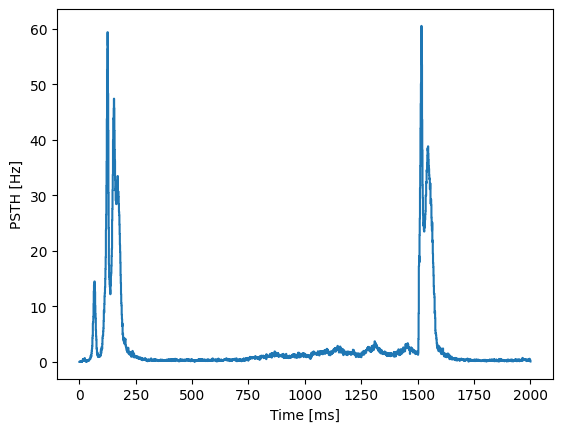

In [23]:
sim.plot.firing_rate_histogram(sample=None);

A classic analysis is to compute the time between 2 spikes for each cells :

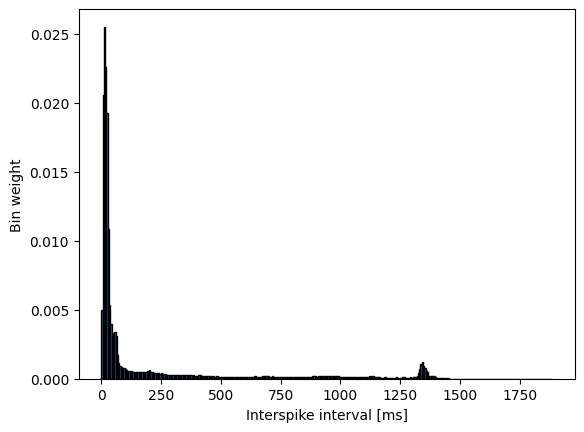

In [24]:
sim.plot.isi(sample=None);

We can see that when a cell spikes more than once most of the time the second spike is less than 250 ms after the last one. 

We can also check easily the timestamps with the most spiking cells.
We can use this is to caracterize the different groups of cells and their behaviors during the simulation.

First lets import some important packages and modules.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from bluepy.enums import Cell


gids = sim.circuit.cells.ids({Cell.MTYPE: 'L4_PC', Cell.HYPERCOLUMN: 2})
spikes = sim.spikes.get(gids=gids)
spikes.head()

t
68.375    70660
71.175    74699
71.950    72374
74.575    71540
74.600    71643
Name: gid, dtype: int64

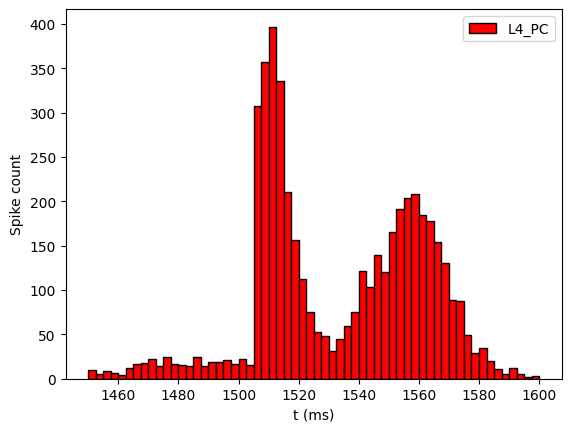

In [26]:
plt.hist(spikes.index, bins=np.linspace(1450, 1600, 61), color='red', edgecolor='black', label='L4_PC')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Spike count');

And an inhibitory m-type for comparison:

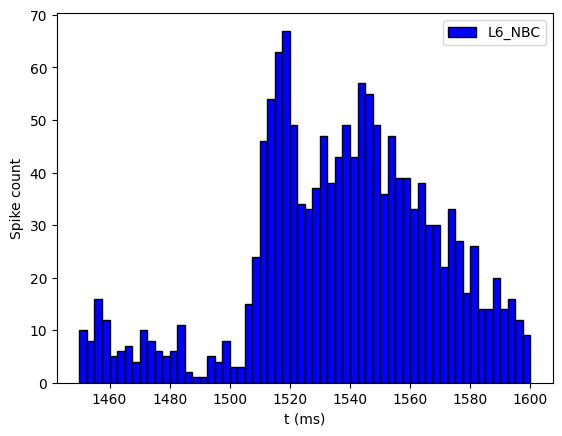

In [27]:
gids = sim.circuit.cells.ids({Cell.MTYPE: 'L6_NBC', Cell.HYPERCOLUMN: 2})
spikes = sim.spikes.get(gids=gids)

plt.hist(spikes.index, bins=np.linspace(1450, 1600, 61), color='blue', edgecolor='black', label='L6_NBC')
plt.legend()
plt.xlabel('t (ms)')
plt.ylabel('Spike count');

If you are interested in the behavior of one cell in particular during the simulation you can use the compartment reports and check the behavior during the simulation:

In [28]:
name = sim.report_names
print(f"report names : {name}")

report names : {'soma'}


In [29]:
report = sim.report("soma")

We can check the metadata :

In [30]:
report.meta

{'start_time': 0.0,
 'end_time': 2000.0,
 'time_step': 0.1,
 'time_unit': 'ms',
 'data_unit': 'mV',
 'frame_count': 20000}

With the `.bbp` reports it can be more efficient to use the time parameters even if set to extrem values:

In [31]:
gid = report.gids[42]
data = report.get_gid(gid, t_end=report.t_end)

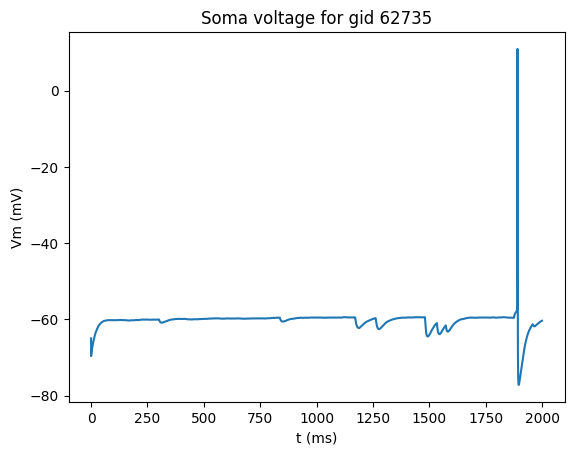

In [32]:
plt.plot(data)
plt.xlabel('t (ms)')
plt.ylabel('Vm (mV)')
plt.title('Soma voltage for gid %d'% gid);

We provide a plotting function to do the same plot:

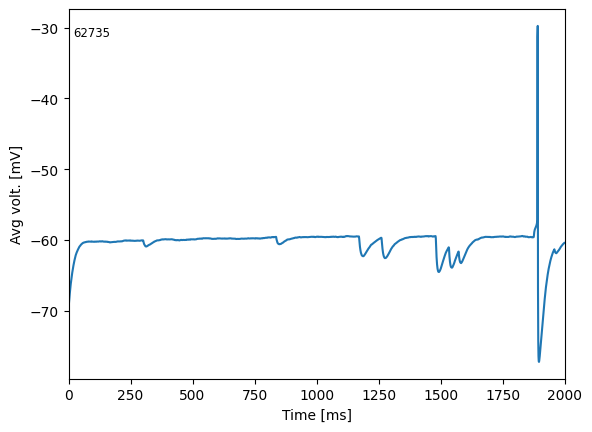

In [33]:
sim.plot.trace("soma", group=gid, t_end=report.t_end);

This function also provides options to do the same trace plot but for group of cells:

In [34]:
gids = report.gids[:5]

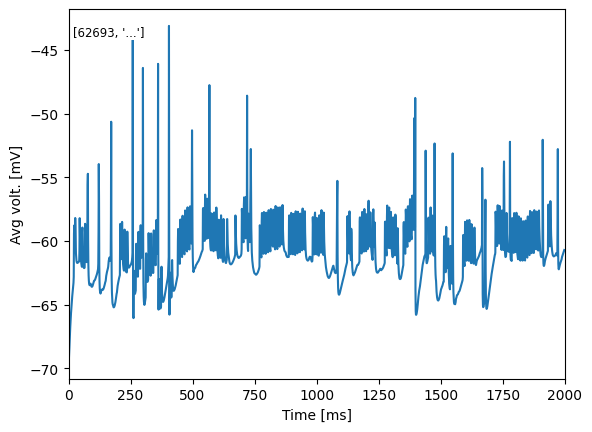

In [35]:
sim.plot.trace("soma", group=gids, t_end=report.t_end);

We also have more complex plotting tools like the `firing_animation`. It provides a simple animation with the positions of each cell firing.

You can choose which axes to display using the x_axis and y_axis.

In [36]:
# disabling this cell as it fails during function CI because of the error: "Your browser does not support the video"
if False:
    from IPython.display import HTML
    anim, ax = sim.plot.firing_animation(x_axis=Cell.X, y_axis=Cell.Y)
    plt.close('all')  # important or you can have an artifact image
    HTML(anim.to_html5_video())

Here is an example of a psth + raster and potention plots used by thalamus:

In [37]:
np.unique(sim.circuit.cells.get(properties=Cell.MTYPE), return_counts=True)

(array(['L1_DAC', 'L1_DLAC', 'L1_HAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC',
        'L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC',
        'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC', 'L4_BP', 'L4_BTC',
        'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC',
        'L4_SBC', 'L4_SP', 'L4_SS', 'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC',
        'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_STPC',
        'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC', 'L6_BP', 'L6_BPC', 'L6_BTC',
        'L6_ChC', 'L6_DBC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC',
        'L6_NGC', 'L6_SBC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC'],
       dtype=object),
 array([  411,   167,   637,   500,   364,   295,   196,   729,   424,
         1224,  3185,  2320,  1872,   390, 41126,  1163,    55,   140,
           56,   273,   854,   820,   668,    42, 18750,   431,  7687,
         2865,   238,   527,   132,   674,  1464,  2784,  1411,    56,
          173,  2116, 16806, 13987,  2403,   488, 22

In [38]:
# disabling this cell as it fails during function CI. The reason is unknown. Even if you use the image generated
# by functional CI, the new run of functional CI will generate another image.

if False:
    fig = sim.plot.population_summary("soma",groups=["L4_NGC", "L4_ChC"])

These kind of plots has been recoded in bluepy but are usually too complex to be shared as a bluepy functionality. That's why we encourage people to share the different plots they are doing in their analyses by adding new examples in the bluepy repository.